In [3]:
import trackhhl.toy.simple_generator as toy
import trackhhl.event_model.q_event_model as em
import numpy as np
import itertools
import copy

from dwave.samplers import SimulatedAnnealingSampler, TabuSampler
import dimod
import psutil
import time
from scipy.sparse import lil_matrix, csc_matrix, block_diag
from dwave.system import DWaveSampler, EmbeddingComposite
import tracemalloc




In [4]:
N_MODULES = 5
LX = float("+inf")
LY = float("+inf")
Z_SPACING = 1.0

detector = toy.SimpleDetectorGeometry(
    module_id=list(range(N_MODULES)),
    lx=[LX] * N_MODULES,
    ly=[LY] * N_MODULES,
    z=[i + Z_SPACING for i in range(N_MODULES)]
)

generator = toy.SimpleGenerator(
    detector_geometry=detector,
    theta_max=np.pi / 6
)



In [5]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse import dok_matrix, csc_matrix
from joblib import Parallel, delayed

def angular_and_bifurcation_checks(i, vectors, norms, segments, N, alpha, eps):
    """Performs angular consistency and bifurcation checks for a given index `i`."""
    results_ang = []
    results_bif = []
    
    vect_i = vectors[i]
    norm_i = norms[i]

    for j in range(i + 1, N):  # Only upper triangle
        vect_j = vectors[j]
        norm_j = norms[j]
        cosine = np.dot(vect_i, vect_j) / (norm_i * norm_j)

        # Angular consistency
        if np.abs(cosine - 1) < eps:
            results_ang.append((i, j, 1))

        # Bifurcation consistency
        seg_i, seg_j = segments[i], segments[j]
        if seg_i.from_hit == seg_j.from_hit and seg_i.to_hit != seg_j.to_hit:
            results_bif.append((i, j, -alpha))
        elif seg_i.from_hit != seg_j.from_hit and seg_i.to_hit == seg_j.to_hit:
            results_bif.append((i, j, -alpha))

    return results_ang, results_bif

def generate_hamiltonian_optimizedPAR(event, params):
    lambda_val = params.get('lambda')
    alpha = params.get('alpha')
    beta = params.get('beta')

    # Sort modules
    modules = sorted(event.modules, key=lambda a: a.z)

    # Generate segments
    segments = [
        em.segment(from_hit, to_hit)
        for idx in range(len(modules) - 1)
        for from_hit, to_hit in itertools.product(modules[idx].hits, modules[idx + 1].hits)
    ]
    
    N = len(segments)
    b = np.zeros(N)

    # Precompute vectors and norms
    vectors = np.array([seg.to_vect() for seg in segments])
    norms = np.linalg.norm(vectors, axis=1)

    eps = 1e-5  # Precision threshold

    # Perform angular and bifurcation checks in parallel
    results = Parallel(n_jobs=-1, backend="loky")(
        delayed(angular_and_bifurcation_checks)(i, vectors, norms, segments, N, alpha, eps)
        for i in range(N)
    )

    # Aggregate results
    A_ang = dok_matrix((N, N), dtype=np.float64)
    A_bif = dok_matrix((N, N), dtype=np.float64)

    for ang_results, bif_results in results:
        for i, j, value in ang_results:
            A_ang[i, j] = value
            A_ang[j, i] = value  # Symmetric
        for i, j, value in bif_results:
            A_bif[i, j] = value
            A_bif[j, i] = value  # Symmetric

    # Convert angular and bifurcation matrices to sparse format
    A_ang = A_ang.tocsc()
    A_bif = A_bif.tocsc()

    # Inhibitory interactions
    module_ids_from = np.array([seg.from_hit.module_id for seg in segments])
    module_ids_to = np.array([seg.to_hit.module_id for seg in segments])
    s_ab = sp.csc_matrix((module_ids_from == 1) & (module_ids_to[:, None] == 1), dtype=int)
    A_inh = s_ab.multiply(s_ab.T) * beta

    # Combine matrices into the Hamiltonian
    A = -1 * (A_ang + A_bif + A_inh)
    true_solution = np.array([1 if segment.truth else 0 for segment in segments])



    return A, b, true_solution


In [6]:
def qubosolverQA(A, b, num_readss):
    # Keep A sparse
    A = csc_matrix(A)

    bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)
    bqm.add_variables_from({i: b[i] for i in range(len(b))})

    row, col = A.nonzero()
    for i, j in zip(row, col):
        if i != j:
            bqm.add_interaction(i, j, A[i, j])

    # Use D-Wave's quantum sampler
    sampler = EmbeddingComposite(DWaveSampler(token='DEV-4ef8a7f5a5857e4e041eb3c24b647bf8433f98a2'))
    response = sampler.sample(bqm, num_reads = num_readss)

    best_sample = response.first.sample
    sol_sample = np.fromiter(best_sample.values(), dtype=int)

    print(f"Solution: {sol_sample}")

    return sol_sample


In [7]:
from dwave.system import LeapHybridSampler
import os
#natalys 2nd token

os.environ['DWAVE_API_TOKEN'] = 'DEV-4ef8a7f5a5857e4e041eb3c24b647bf8433f98a2'
import tracemalloc
import time
import numpy as np
from scipy.sparse import csc_matrix
from dimod import BinaryQuadraticModel

def qubosolverHr(A, b, num_readss):
   
    # Keep A sparse
    A = csc_matrix(A)
    bqm = BinaryQuadraticModel.empty(dimod.BINARY)

    # Add the linear terms from vector b
    bqm.add_variables_from({i: b[i] for i in range(len(b))})

    row, col = A.nonzero()  # Get non-zero entries in the matrix A
    for i, j in zip(row, col):
        if i != j:  # Only consider off-diagonal terms (interactions)
            bqm.add_interaction(i, j, A[i, j])

    sampler = LeapHybridSampler()
    response = sampler.sample(bqm)


    best_sample = response.first.sample
    sol_sample = np.fromiter(best_sample.values(), dtype=int)

    # Output solution and performance details
    print(f"Solution: {sol_sample}")
    return sol_sample
#qubosolverHr(A, b)

In [8]:
def qubosolverSA(A, b, num_readss):
    A = csc_matrix(A)

    bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)

    #vectors for efficiency 
    bqm.add_variables_from({i: b[i] for i in range(len(b))})

    row, col = A.nonzero()  
    for i, j in zip(row, col):
        if i != j:  
            bqm.add_interaction(i, j, A[i, j])

    sampler = SimulatedAnnealingSampler()
    response = sampler.sample(bqm, num_reads = num_readss)

    best_sample = response.first.sample
    sol_sample = np.fromiter(best_sample.values(), dtype=int)  


    print(f"Solution:{sol_sample}")


    return sol_sample

In [9]:
import csv 
def collect_convergence_data(hamiltonian_generator, qubosolvers, event, params, max_iterations, save_path, save_format):
    """
    Collect convergence data for multiple QUBO solvers using true solution as the baseline.

    Parameters:
    - hamiltonian_generator: Function to generate the Hamiltonian matrix.
    - qubosolvers: Dictionary of solvers (name -> function).
    - event: The event data used by the Hamiltonian generator.
    - params: Parameters for the Hamiltonian generator.
    - max_iterations: Maximum number of iterations to track.

    Returns:
    - convergence_results: Dictionary containing convergence data for each solver.
    """

    # Generate the Hamiltonian
    A, b, true_solution = hamiltonian_generator(event, params)

    # Initialize results dictionary
    convergence_results = {}

    # Loop through solvers
    for solver_name, solver_function in qubosolvers.items():
        print(f"Collecting convergence data for {solver_name}...")
        accuracy_over_iterations = []  # Track accuracy over iterations

        # Track accuracy (Hamming distance from true_solution) over iterations
        for iteration in range(1, max_iterations + 1):
            solution = solver_function(A, b, iteration)  # Run the solver for this iteration

            # Calculate accuracy as fraction of correctly predicted bits
            accuracy = np.mean(solution == true_solution)
            accuracy_over_iterations.append(accuracy)

        # Store results
        convergence_results[solver_name] = accuracy_over_iterations
    if save_path:
        if save_format == "csv":
            with open(save_path, 'w', newline='') as f:
                writer = csv.writer(f)
                # Write header
                writer.writerow(["Iteration"] + list(convergence_results.keys()))
                # Write rows
                for i in range(max_iterations):
                    row = [i + 1] + [convergence_results[solver][i] for solver in convergence_results]
                    writer.writerow(row)
            print(f"Results saved to {save_path} in CSV format.")
        else:
            print(f"Unsupported save format: {save_format}. Results not saved.")
        return convergence_results


In [ ]:
# Define solvers
solvers = {
    "Simulated Annealing": qubosolverSA,
    #"Hybrid Solver": qubosolverHr,
    "Quantum Annealing": qubosolverQA,
}

# Define parameters for the Hamiltonian generator
params = {
    'alpha': 1.0,
    'beta': 1.0,
    'lambda': 100.0,
}

# Generate a particle track event
event = generator.generate_event(7)

save_path = "convergence_results.csv"
# Collect convergence data
convergence_results = collect_convergence_data(
    hamiltonian_generator=generate_hamiltonian_optimizedPAR,
    qubosolvers=solvers,
    event=event,
    params=params,
    max_iterations = 100,
    save_path=save_path,
    save_format="csv"
)




Solution:[1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 1]
Solution:[1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 1]
Solution:[1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 1 0 0 0 0 

NameError: name 'max_iterations' is not defined

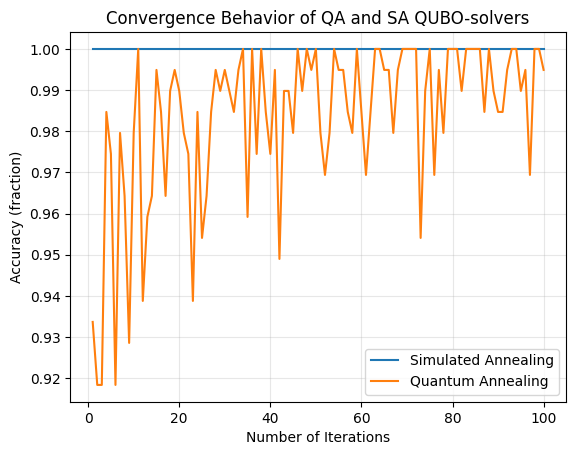

In [5]:
import matplotlib.pyplot as plt
import csv

file_path = "convergence_results.csv"

# Initialize storage for results
convergence_results = {}
iterations = []

# Read the CSV and store results
with open(file_path, 'r') as f:
    reader = csv.reader(f)
    header = next(reader)  # Read header
    solvers = header[1:]  # Solver names (skip 'Iteration')
    for solver in solvers:
        convergence_results[solver] = []

    # Read each row of the CSV
    for row in reader:
        iterations.append(int(row[0]))  # Store iteration numbers
        for i, solver in enumerate(solvers):
            convergence_results[solver].append(float(row[i + 1]))

# Plot convergence behavior
for solver_name, accuracies in convergence_results.items():
    plt.plot(iterations, accuracies, label=solver_name)

plt.title("Convergence Behavior of QA and SA QUBO-solvers")
plt.xlabel("Number of Iterations")
plt.ylabel("Accuracy (fraction)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Quantum Annealing Statistics:
  Mean Accuracy: 0.9834
  Std Deviation: 0.0198
  Min Accuracy: 0.9184
  Max Accuracy: 1.0000
  Largest Oscillation Range (10-iteration window): 0.0816


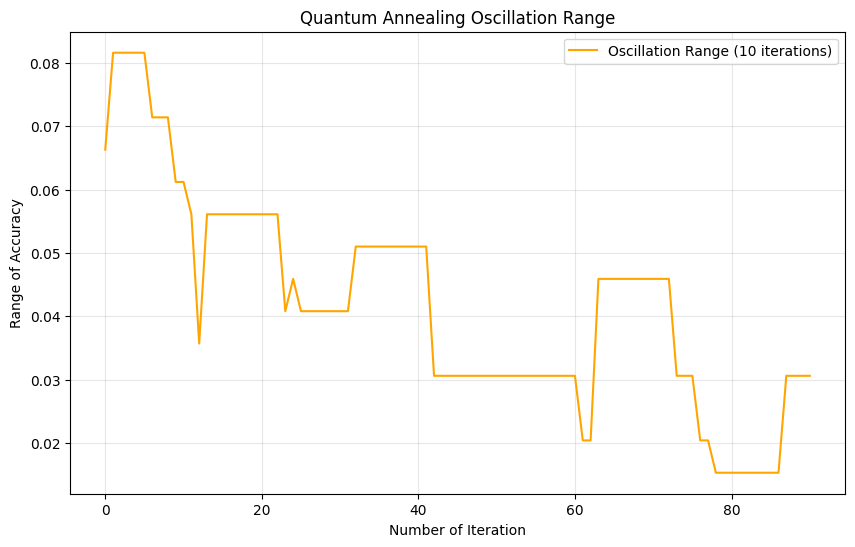

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Example extracted data from your graph
iterations = np.arange(1, 101)  # 100 iterations
simulated_annealing = np.ones(100)  # Constant 1.0 accuracy
quantum_annealing = [0.9336734693877551, 0.9183673469387755, 0.9183673469387755, 0.9846938775510204, 
                     0.9744897959183674, 0.9183673469387755, 0.9795918367346939, 0.9642857142857143,
                     0.9285714285714286, 0.9795918367346939, 1.0, 0.9387755102040817, 0.9591836734693877, 
                     0.9642857142857143, 0.9948979591836735, 0.9846938775510204, 0.9642857142857143, 
                     0.9897959183673469, 0.9948979591836735, 0.9897959183673469, 0.9795918367346939, 
                     0.9744897959183674, 0.9387755102040817, 0.9846938775510204, 0.9540816326530612, 
                     0.9642857142857143, 0.9846938775510204, 0.9948979591836735, 0.9897959183673469, 
                     0.9948979591836735, 0.9897959183673469, 0.9846938775510204, 0.9948979591836735, 
                     1.0, 0.9591836734693877, 1.0, 0.9744897959183674, 1.0, 0.9846938775510204, 
                     0.9744897959183674, 0.9948979591836735, 0.9489795918367347, 0.9897959183673469, 
                     0.9897959183673469, 0.9795918367346939, 1.0, 0.9897959183673469, 1.0, 0.9948979591836735,
                     1.0, 0.9795918367346939, 0.9693877551020408, 0.9795918367346939, 1.0, 0.9948979591836735,
                     0.9948979591836735, 0.9846938775510204, 0.9795918367346939, 1.0, 0.9846938775510204, 
                     0.9693877551020408, 0.9846938775510204, 1.0, 1.0, 0.9948979591836735, 0.9948979591836735,
                     0.9795918367346939, 0.9948979591836735, 1.0, 1.0, 1.0, 1.0, 0.9540816326530612, 
                     0.9897959183673469, 1.0, 0.9693877551020408, 0.9948979591836735, 0.9795918367346939,
                     1.0, 1.0, 1.0, 0.9897959183673469, 1.0, 1.0, 1.0, 1.0, 0.9846938775510204, 1.0,
                     0.9897959183673469, 0.9846938775510204, 0.9846938775510204, 0.9948979591836735, 1.0,
                     1.0, 0.9897959183673469, 0.9948979591836735, 0.9693877551020408, 1.0, 1.0, 0.9948979591836735]

# Convert to NumPy array for processing
quantum_annealing = np.array(quantum_annealing)

# Compute statistics for Quantum Annealing
mean_accuracy = np.mean(quantum_annealing)
std_accuracy = np.std(quantum_annealing)
min_accuracy = np.min(quantum_annealing)
max_accuracy = np.max(quantum_annealing)

# Compute range of oscillations (max-min window)
rolling_window_size = 10
rolling_ranges = [np.ptp(quantum_annealing[i:i + rolling_window_size]) for i in range(len(quantum_annealing) - rolling_window_size + 1)]

# Print key statistics
print(f"Quantum Annealing Statistics:")
print(f"  Mean Accuracy: {mean_accuracy:.4f}")
print(f"  Std Deviation: {std_accuracy:.4f}")
print(f"  Min Accuracy: {min_accuracy:.4f}")
print(f"  Max Accuracy: {max_accuracy:.4f}")
print(f"  Largest Oscillation Range (10-iteration window): {max(rolling_ranges):.4f}")

# Plot the rolling oscillation range
plt.figure(figsize=(10, 6))
plt.plot(range(len(rolling_ranges)), rolling_ranges, label="Oscillation Range (10 iterations)", color='orange')
plt.title("Quantum Annealing Oscillation Range")
plt.xlabel("Number of Iteration")
plt.ylabel("Range of Accuracy")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [9]:
def add_tracking_noise(event, sigma_position, sigma_angle):
    """
    Add noise to an event for particle track reconstruction.

    Parameters:
    - event: The event data containing hits and modules.
    - sigma_position: Standard deviation of noise in hit positions.
    - sigma_angle: Standard deviation of angular noise for segments.

    Returns:
    - event: Noisy event.
    """
    # Add noise to hit positions
    for module in event.modules:
        for hit in module.hits:
            hit.x += np.random.normal(0, sigma_position)
            hit.y += np.random.normal(0, sigma_position)

    return event

In [15]:
import json
import numpy as np
import time
#noice, gaussian stuff added to the hit positions
def compare_solvers_over_noise(hamiltonian_generator, qubosolvers, N_PARTICLES, noise_levels, save_path):
    """
    Compare multiple QUBO solvers over a range of noise levels.

    Parameters:
    - hamiltonian_generator: Function to generate the Hamiltonian matrix.
    - qubosolvers: Dictionary of solvers (name -> function).
    - N_PARTICLES: Number of particles for event generation.
    - noise_levels: List of noise levels to simulate.
    - save_path: Path to save the results in JSON format.

    Returns:
    - results: Dictionary containing the comparison data.
    """
    # Set Hamiltonian generator parameters
    params = {
        'alpha': 1.0,
        'beta': 1.0,
        'lambda': 100.0,
    }

    # Initialize results dictionary
    results = {"noise_levels": noise_levels, "solvers": {}}

    # Loop through solvers
    for solver_name, solver_function in qubosolvers.items():
        results["solvers"][solver_name] = {"accuracy": [], "runtime": []}

        # Loop through noise levels
        for noise in noise_levels:
            # Generate a noisy event for the current noise level
            event = generator.generate_event(N_PARTICLES)
            noisy_event = add_tracking_noise(event, sigma_position=noise, sigma_angle=noise)

            # Generate Hamiltonian from noisy event
            A, b, true_solution = hamiltonian_generator(noisy_event, params)

            # Time the solver
            start_time = time.time()
            solution = solver_function(A, b, 100)
            runtime = time.time() - start_time

            # Calculate accuracy
            accuracy = np.mean(solution == true_solution)

            # Save results
            results["solvers"][solver_name]["accuracy"].append(accuracy)
            results["solvers"][solver_name]["runtime"].append(runtime)

    # Save results to file
    with open(save_path, 'w') as f:
        json.dump(results, f)

    return results

solvers = {
    "Simulated Annealing": qubosolverSA,
    "Hybrid Solver": qubosolverHr,
    "Quantum Annealing": qubosolverQA,
}
save_path= 'noiceEVENLONGER.json'
# Define parameters
noise_levels = [0.001, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, 0.1]
compare_solvers_over_noise(hamiltonian_generator= generate_hamiltonian_optimizedPAR,
    qubosolvers=solvers,
    N_PARTICLES=7,
    noise_levels=noise_levels,
    save_path=save_path
)

Solution:[1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 1]
Solution:[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 1 0 0]
Solution:[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 

{'noise_levels': [0.001,
  0.005,
  0.01,
  0.015,
  0.02,
  0.025,
  0.03,
  0.035,
  0.04,
  0.045,
  0.05,
  0.055,
  0.06,
  0.07,
  0.075,
  0.08,
  0.085,
  0.09,
  0.095,
  0.1],
 'solvers': {'Simulated Annealing': {'accuracy': [np.float64(1.0),
    np.float64(0.8673469387755102),
    np.float64(0.7908163265306123),
    np.float64(0.826530612244898),
    np.float64(0.7653061224489796),
    np.float64(0.7755102040816326),
    np.float64(0.7704081632653061),
    np.float64(0.7653061224489796),
    np.float64(0.7755102040816326),
    np.float64(0.7857142857142857),
    np.float64(0.7602040816326531),
    np.float64(0.7959183673469388),
    np.float64(0.8112244897959183),
    np.float64(0.7806122448979592),
    np.float64(0.7857142857142857),
    np.float64(0.7857142857142857),
    np.float64(0.7653061224489796),
    np.float64(0.8061224489795918),
    np.float64(0.7704081632653061),
    np.float64(0.7959183673469388)],
   'runtime': [0.5143799781799316,
    0.45900750160217285,
   

<>:59: SyntaxWarning: invalid escape sequence '\s'
<>:71: SyntaxWarning: invalid escape sequence '\s'
<>:59: SyntaxWarning: invalid escape sequence '\s'
<>:71: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_5680/3361815555.py:59: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel("Noise Levels ($\sigma_{\mathrm{position}}$, $\sigma_{\mathrm{angle}}$)")
/tmp/ipykernel_5680/3361815555.py:71: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel("Noise Levels ($\sigma_{\mathrm{position}}$, $\sigma_{\mathrm{angle}}$)")


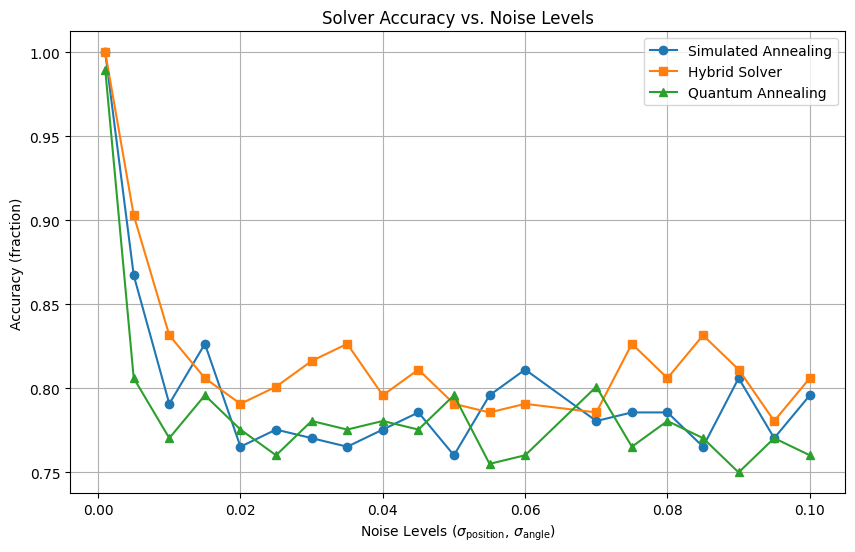

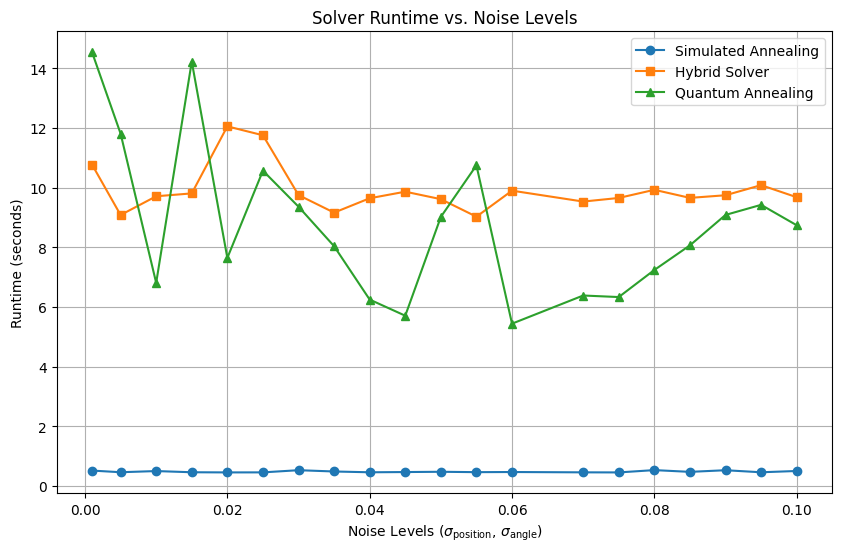

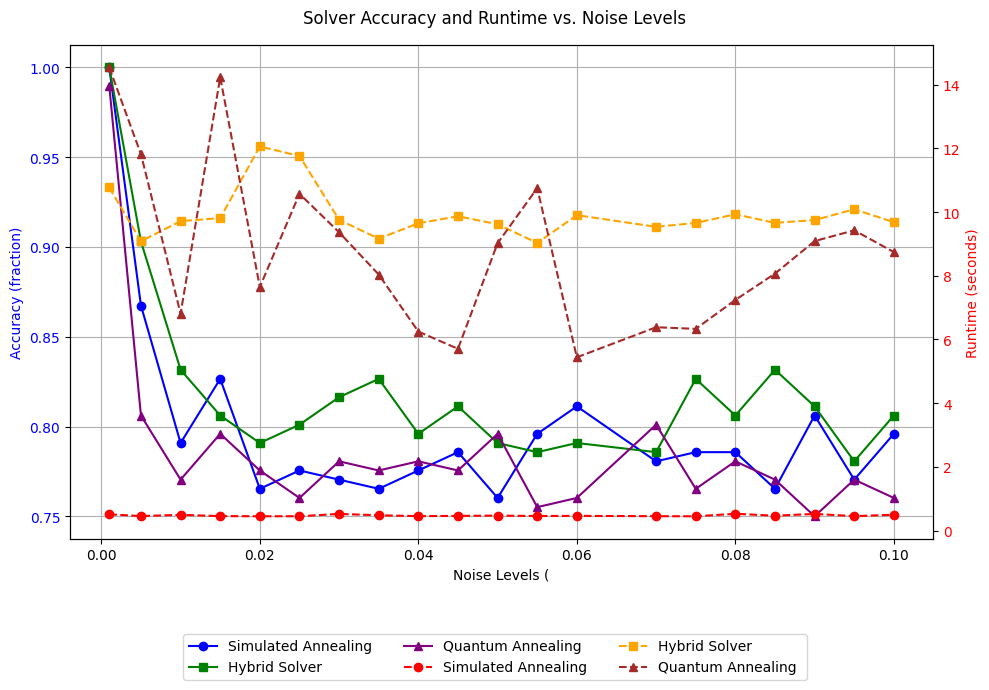

In [22]:
import matplotlib.pyplot as plt

# Data
# Data
noise_levels = [0.001, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 
                0.055, 0.06, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, 0.1]

sa_accuracy = [1.0, 0.8673469387755102, 0.7908163265306123, 0.826530612244898, 
               0.7653061224489796, 0.7755102040816326, 0.7704081632653061, 
               0.7653061224489796, 0.7755102040816326, 0.7857142857142857, 
               0.7602040816326531, 0.7959183673469388, 0.8112244897959183, 
               0.7806122448979592, 0.7857142857142857, 0.7857142857142857, 
               0.7653061224489796, 0.8061224489795918, 0.7704081632653061, 
               0.7959183673469388]
sa_runtime = [0.5143799781799316, 0.45900750160217285, 0.4980907440185547, 
              0.45815014839172363, 0.45282673835754395, 0.4541449546813965, 
              0.527015209197998, 0.4839444160461426, 0.45717859268188477, 
              0.46488213539123535, 0.47411489486694336, 0.46141934394836426, 
              0.4659867286682129, 0.45522093772888184, 0.45252513885498047, 
              0.5302267074584961, 0.4713101387023926, 0.5261619091033936, 
              0.45748209953308105, 0.5007264614105225]

hs_accuracy = [1.0, 0.9030612244897959, 0.8316326530612245, 0.8061224489795918, 
               0.7908163265306123, 0.8010204081632653, 0.8163265306122449, 
               0.826530612244898, 0.7959183673469388, 0.8112244897959183, 
               0.7908163265306123, 0.7857142857142857, 0.7908163265306123, 
               0.7857142857142857, 0.826530612244898, 0.8061224489795918, 
               0.8316326530612245, 0.8112244897959183, 0.7806122448979592, 
               0.8061224489795918]
hs_runtime = [10.770196914672852, 9.084744453430176, 9.713195085525513, 
              9.809438228607178, 12.057497024536133, 11.758632183074951, 
              9.753519058227539, 9.164390087127686, 9.646377563476562, 
              9.866800546646118, 9.616128206253052, 9.02835988998413, 
              9.900915145874023, 9.535434246063232, 9.656370401382446, 
              9.929728031158447, 9.658967733383179, 9.747074604034424, 
              10.086183547973633, 9.681387662887573]

qa_accuracy = [0.9897959183673469, 0.8061224489795918, 0.7704081632653061, 
               0.7959183673469388, 0.7755102040816326, 0.7602040816326531, 
               0.7806122448979592, 0.7755102040816326, 0.7806122448979592, 
               0.7755102040816326, 0.7959183673469388, 0.7551020408163265, 
               0.7602040816326531, 0.8010204081632653, 0.7653061224489796, 
               0.7806122448979592, 0.7704081632653061, 0.75, 0.7704081632653061, 
               0.7602040816326531]
qa_runtime = [14.536804676055908, 11.813505172729492, 6.80908203125, 
              14.229084253311157, 7.645789384841919, 10.571191310882568, 
              9.363795757293701, 8.03857421875, 6.248535394668579, 
              5.707631587982178, 9.020987510681152, 10.749745607376099, 
              5.4410240650177, 6.384992599487305, 6.333177089691162, 
              7.240875959396362, 8.067439556121826, 9.087526798248291, 
              9.425442934036255, 8.741769313812256]


# Line Plot for Accuracy
plt.figure(figsize=(10, 6))
plt.plot(noise_levels, sa_accuracy, label="Simulated Annealing", marker="o")
plt.plot(noise_levels, hs_accuracy, label="Hybrid Solver", marker="s")
plt.plot(noise_levels, qa_accuracy, label="Quantum Annealing", marker="^")
plt.xlabel("Noise Levels ($\sigma_{\mathrm{position}}$, $\sigma_{\mathrm{angle}}$)")
plt.ylabel("Accuracy (fraction)")
plt.title("Solver Accuracy vs. Noise Levels")
plt.legend()
plt.grid(True)
plt.show()

# Line Plot for Runtime
plt.figure(figsize=(10, 6))
plt.plot(noise_levels, sa_runtime, label="Simulated Annealing", marker="o")
plt.plot(noise_levels, hs_runtime, label="Hybrid Solver", marker="s")
plt.plot(noise_levels, qa_runtime, label="Quantum Annealing", marker="^")
plt.xlabel("Noise Levels ($\sigma_{\mathrm{position}}$, $\sigma_{\mathrm{angle}}$)")
plt.ylabel("Runtime (seconds)")
plt.title("Solver Runtime vs. Noise Levels")
plt.legend()
plt.grid(True)
plt.show()

# Combined Plot: Accuracy and Runtime
fig, ax1 = plt.subplots(figsize=(10, 6))

# Accuracy on the left y-axis
ax1.plot(noise_levels, sa_accuracy, label="Simulated Annealing ", color="blue", marker="o")
ax1.plot(noise_levels, hs_accuracy, label="Hybrid Solver ", color="green", marker="s")
ax1.plot(noise_levels, qa_accuracy, label="Quantum Annealing ", color="purple", marker="^")
ax1.set_xlabel("Noise Levels (")
ax1.set_ylabel("Accuracy (fraction)", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")
ax1.grid(True)

# Runtime on the right y-axis
ax2 = ax1.twinx()
ax2.plot(noise_levels, sa_runtime, label="Simulated Annealing ", color="red", linestyle="--", marker="o")
ax2.plot(noise_levels, hs_runtime, label="Hybrid Solver", color="orange", linestyle="--", marker="s")
ax2.plot(noise_levels, qa_runtime, label="Quantum Annealing ", color="brown", linestyle="--", marker="^")
ax2.set_ylabel("Runtime (seconds)", color="red")
ax2.tick_params(axis='y', labelcolor="red")

# Title and Legend
fig.suptitle("Solver Accuracy and Runtime vs. Noise Levels")
fig.tight_layout()
fig.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=3)
plt.show()


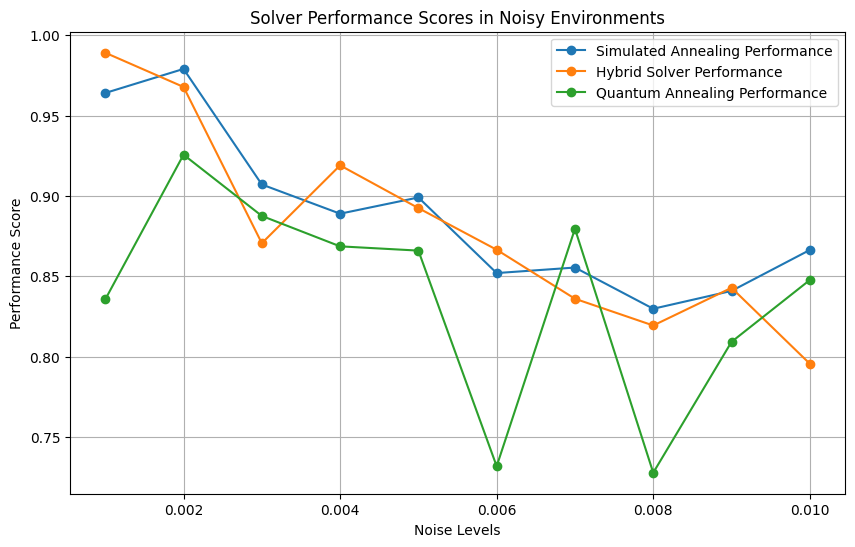

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Data
noise_levels = np.array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01])
sa_accuracy = np.array([1.0, 0.9795918367346939, 0.8673469387755102, 0.8418367346938775,
                        0.8979591836734694, 0.8673469387755102, 0.7959183673469388,
                        0.7704081632653061, 0.7959183673469388, 0.8112244897959183])
sa_runtime = np.array([0.5221836566925049, 0.470078706741333, 0.45967817306518555, 0.46018099784851074,
                       0.5098297595977783, 0.5632050037384033, 0.46230316162109375, 0.4747166633605957,
                       0.48601317405700684, 0.461961030960083])
hs_accuracy = np.array([1.0, 0.9540816326530612, 0.8979591836734694, 0.9030612244897959,
                        0.8673469387755102, 0.8418367346938775, 0.8010204081632653,
                        0.8316326530612245, 0.7806122448979592, 0.8214285714285714])
hs_runtime = np.array([10.167665958404541, 9.800376653671265, 12.148946762084961, 10.247549295425415,
                       10.305114269256592, 10.60526180267334, 10.679672956466675, 12.39390516281128,
                       9.919597864151001, 13.329343795776367])
qa_accuracy = np.array([0.9846938775510204, 0.9795918367346939, 0.8877551020408163, 0.9030612244897959,
                        0.8316326530612245, 0.8112244897959183, 0.8163265306122449,
                        0.7704081632653061, 0.7806122448979592, 0.7704081632653061])
qa_runtime = np.array([14.854636669158936, 8.782946586608887, 7.852715492248535, 8.88581657409668,
                       7.329554319381714, 12.988264560699463, 6.7305238246917725, 11.186258554458618,
                       7.921636343002319, 6.7135748863220215])

# Normalize metrics
accuracy_normalized = {
    "Simulated Annealing": sa_accuracy / np.max(sa_accuracy),
    "Hybrid Solver": hs_accuracy / np.max(hs_accuracy),
    "Quantum Annealing": qa_accuracy / np.max(qa_accuracy),
}

runtime_normalized = {
    "Simulated Annealing": np.min(sa_runtime) / sa_runtime,  # Inverse to make lower runtime better
    "Hybrid Solver": np.min(hs_runtime) / hs_runtime,
    "Quantum Annealing": np.min(qa_runtime) / qa_runtime,
}

# Performance score (weighted average)
alpha, beta = 0.7, 0.3  # Weights: prioritize accuracy over runtime
performance_scores = {
    solver: alpha * accuracy + beta * runtime
    for solver, (accuracy, runtime) in zip(
        accuracy_normalized.keys(), zip(accuracy_normalized.values(), runtime_normalized.values())
    )
}

# Plot Performance Scores
plt.figure(figsize=(10, 6))
for solver, scores in performance_scores.items():
    plt.plot(noise_levels, scores, label=f"{solver} Performance", marker="o")

plt.xlabel("Noise Levels")
plt.ylabel("Performance Score")
plt.title("Solver Performance Scores in Noisy Environments")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from scipy.spatial.distance import hamming
from scipy.sparse import csc_matrix

import numpy as np

def calculate_accuracy_metrics(true_solution, solver_solution):
    true_solution = np.array(true_solution)
    solver_solution = np.array(solver_solution)
    
    #total `1`s in true_solution
    N_gen_hit = np.sum(true_solution == 1)
    
    #number of `1`s in solver_solution that match `1`s in true_solution)
    N_correct_hit = np.sum((true_solution == 1) & (solver_solution == 1))
    
    # Hit-efficiency (e_eff): Fraction of true hits that are correctly identified in solver_solution
    e_eff = N_correct_hit / N_gen_hit if N_gen_hit > 0 else 0

    N_all_track = np.sum(solver_solution == 1)
    N_fake_track = N_all_track - N_correct_hit
    
    #fraction of found tracks that are not associated with a true hit
    f_fake = N_fake_track / N_all_track if N_all_track > 0 else 0
    
    #Fraction of hits in solver_solution that are correctly assigned
    e_pure = N_correct_hit / N_all_track if N_all_track > 0 else 0
    
    return e_eff, f_fake, e_pure

import pickle
import pandas as pd
import numpy as np
from scipy.sparse import csc_matrix

def save_progress(pickle_file, data):
    """Save data to a pickle file, overwriting the file each time."""
    with open(pickle_file, 'wb') as f:
        pickle.dump(data, f)

def load_progress(pickle_file):
    """Load data from a pickle file, or return an empty list if the file doesn't exist."""
    try:
        with open(pickle_file, 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        return []

def compare_qubo_solvers(N_PARTICLES_LIST, params, pickle_file='progress.pkl'):
    results = load_progress(pickle_file)  # Load previously saved progress

    # Initialize flags to track which solvers should continue
    qubosolverSA_active = True
    qubosolverHr_active = True
    qubosolverQA_active = False

    for N_PARTICLES in N_PARTICLES_LIST:
        try:
            # Check if N_PARTICLES has already been processed
            if any(res["N_PARTICLES"] == N_PARTICLES for res in results):
                print(f"N_PARTICLES={N_PARTICLES} already processed. Skipping.")
                continue

            # Generate event and matrix
            event = generator.generate_event(N_PARTICLES)
            A, b, true_solution = generate_hamiltonian_optimizedPAR(event, params)
            A = csc_matrix(A)
            b = np.array(b, dtype=np.int8)

            # Save true_solution for this N_PARTICLES
            results.append({"N_PARTICLES": N_PARTICLES, "Solver": "TrueSolution", 
                            "Solution": true_solution.tolist()})
            save_progress(pickle_file, results)

            # Only attempt qubosolverSA if it hasn't encountered an error previously
            if qubosolverSA_active:
                try:
                    sol1 = np.array(qubosolverSA(A, b), dtype=np.int8)
                    accuracy_1 = calculate_accuracy_metrics(true_solution, sol1)
                    results.append({"N_PARTICLES": N_PARTICLES, "Solver": "qubosolverSA", 
                                    "Hit Efficiency": accuracy_1[0],
                                    "Fake Rates": accuracy_1[1], 
                                    "Hit Purity": accuracy_1[2],
                                    "Solution": sol1.tolist()})
                    save_progress(pickle_file, results)
                except Exception as e:
                    print(f"Error with qubosolverSA for N_PARTICLES={N_PARTICLES}: {e}")
                    qubosolverSA_active = False  # Deactivate further testing of qubosolverSA

            # Only attempt qubosolverHr if it hasn't encountered an error previously
            if qubosolverHr_active:
                try:
                    sol2 = np.array(qubosolverHr(A, b), dtype=np.int8)
                    accuracy_2 = calculate_accuracy_metrics(true_solution, sol2)
                    results.append({"N_PARTICLES": N_PARTICLES, "Solver": "qubosolverHr", 
                                    "Hit Efficiency": accuracy_2[0],
                                    "Fake Rates": accuracy_2[1], 
                                    "Hit Purity": accuracy_2[2],
                                    "Solution": sol2.tolist()})
                    save_progress(pickle_file, results)
                except Exception as e:
                    print(f"Error with qubosolverHr for N_PARTICLES={N_PARTICLES}: {e}")
                    qubosolverHr_active = False  # Deactivate further testing of qubosolverHr

            # Only attempt qubosolverQA if it hasn't encountered an error previously
            if qubosolverQA_active:
                try:
                    sol3 = np.array(qubosolverQA(A, b), dtype=np.int8)
                    accuracy_3 = calculate_accuracy_metrics(true_solution, sol3)
                    results.append({"N_PARTICLES": N_PARTICLES, "Solver": "qubosolverQA", 
                                    "Hit Efficiency": accuracy_3[0],
                                    "Fake Rates": accuracy_3[1], 
                                    "Hit Purity": accuracy_3[2],
                                    "Solution": sol3.tolist()})
                    save_progress(pickle_file, results)
                except Exception as e:
                    print(f"Error with qubosolverQA for N_PARTICLES={N_PARTICLES}: {e}")
                    qubosolverQA_active = False  # Deactivate further testing of qubosolverQA

        except MemoryError as mem_err:
            print(f"MemoryError encountered for N_PARTICLES={N_PARTICLES}: {mem_err}")
            continue

        except Exception as e:
            print(f"An error occurred while preparing for N_PARTICLES={N_PARTICLES}: {e}")
            continue

    results_df = pd.DataFrame(results)
    results_df.to_csv("qubo_solver_results.csv", index=False)
    return results_df

# Parameters and Particle List
params = {'alpha': 1.0, 'beta': 1.0, 'lambda': 100.0}
N_PARTICLES_LIST = [5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Run the comparison function and save the results
results_df = compare_qubo_solvers(N_PARTICLES_LIST, params)
results_df.to_csv("qubossolutioncomparisment.csv", index=False)



Solution:[1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0
 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1]
Solution: [1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0
 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1]
Solution:[1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 

In [ ]:
#data for 80 particles 5 layers, QA< SA AND HYBRID

import pandas as pd

# Load the previously saved CSV file
results_df = pd.read_csv("qubos80particleSOLUTIONSTESTING.csv")

latex_table = results_df.to_latex(index=False, float_format="%.2f", 
                                    caption="Comparison of QUBO Solvers on Particle Tracks",
                                    label="tab:qubo_solver_results")

# Save LaTeX table to file
with open("qubo_solver_results.tex", "w") as file:
    file.write(latex_table)



 N_PARTICLES       Solver  Percentage_Similarity  Hamming_Distance  Simple_Matching_Coefficient
           2 qubosolverSA              100.00000                 0                      1.00000
           2 qubosolverHr              100.00000                 0                      1.00000
           2 qubosolverQA              100.00000                 0                      1.00000
           4 qubosolverSA              100.00000                 0                      1.00000
           4 qubosolverHr              100.00000                 0                      1.00000
           4 qubosolverQA              100.00000                 0                      1.00000
           6 qubosolverSA              100.00000                 0                      1.00000
           6 qubosolverHr              100.00000                 0                      1.00000
           6 qubosolverQA               98.61110                 1                      0.98610
           8 qubosolverSA              1

In [3]:
import pandas as pd
import numpy as np

# Define the data with inconsistent lengths
data = {
    "N_PARTICLES": [2, 2, 2, 4, 4, 4, 6, 6, 6, 8, 8, 8, 10, 10, 10, 12, 12, 14, 14, 16, 16, 18, 18, 20, 20],
    "Solver": ["qubosolverSA", "qubosolverHr", "qubosolverQA", "qubosolverSA", "qubosolverHr", "qubosolverQA", "qubosolverSA", "qubosolverHr", "qubosolverQA", "qubosolverSA", "qubosolverHr", "qubosolverQA", "qubosolverSA", "qubosolverHr", "qubosolverQA", "qubosolverSA", "qubosolverHr", "qubosolverSA", "qubosolverHr", "qubosolverSA", "qubosolverHr", "qubosolverSA", "qubosolverHr", "qubosolverSA", "qubosolverHr"],
    "Hit Efficiency": [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6875, 1.0, 1.0, 0.475, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
    "Fake Rate": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2143, 0.0, 0.0, 0.3667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    "Hit Purity": [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7857, 1.0, 1.0, 0.6333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
}

# Find the maximum length of the data arrays
max_length = max(len(column) for column in data.values())

# Pad all columns to the same length
for key in data.keys():
    if len(data[key]) < max_length:
        data[key].extend([np.nan] * (max_length - len(data[key])))

# Create the DataFrame
results_df = pd.DataFrame(data)

# Display the DataFrame
print(results_df)

    N_PARTICLES        Solver  Hit Efficiency  Fake Rate  Hit Purity
0             2  qubosolverSA          1.0000     0.0000      1.0000
1             2  qubosolverHr          1.0000     0.0000      1.0000
2             2  qubosolverQA          1.0000     0.0000      1.0000
3             4  qubosolverSA          1.0000     0.0000      1.0000
4             4  qubosolverHr          1.0000     0.0000      1.0000
5             4  qubosolverQA          1.0000     0.0000      1.0000
6             6  qubosolverSA          1.0000     0.0000      1.0000
7             6  qubosolverHr          1.0000     0.0000      1.0000
8             6  qubosolverQA          1.0000     0.0000      1.0000
9             8  qubosolverSA          1.0000     0.0000      1.0000
10            8  qubosolverHr          1.0000     0.0000      1.0000
11            8  qubosolverQA          0.6875     0.2143      0.7857
12           10  qubosolverSA          1.0000     0.0000      1.0000
13           10  qubosolverHr     

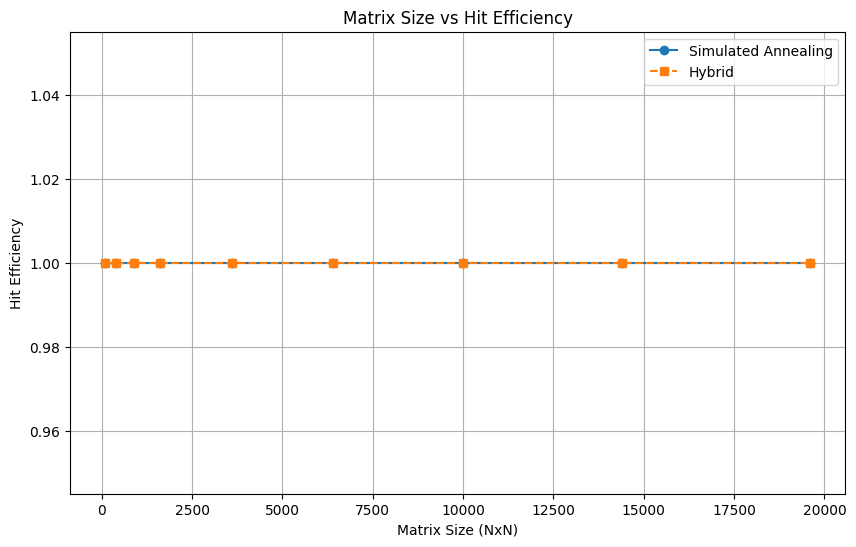

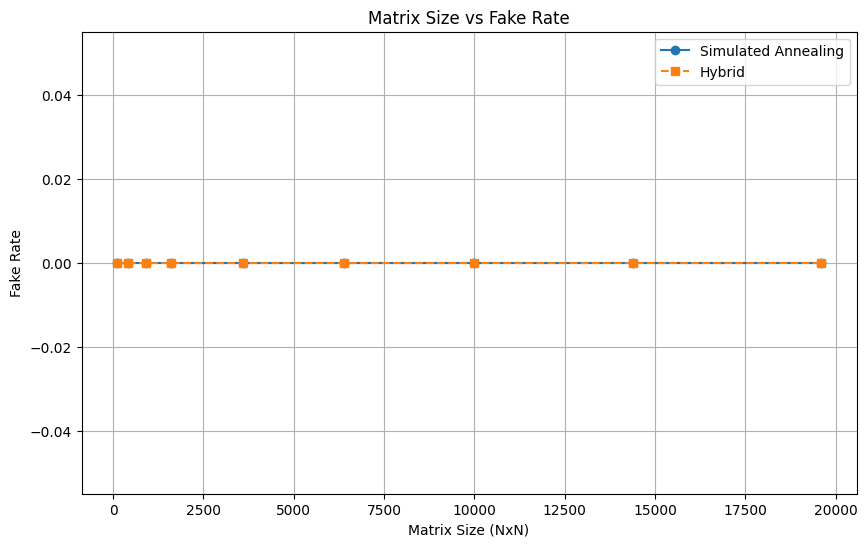

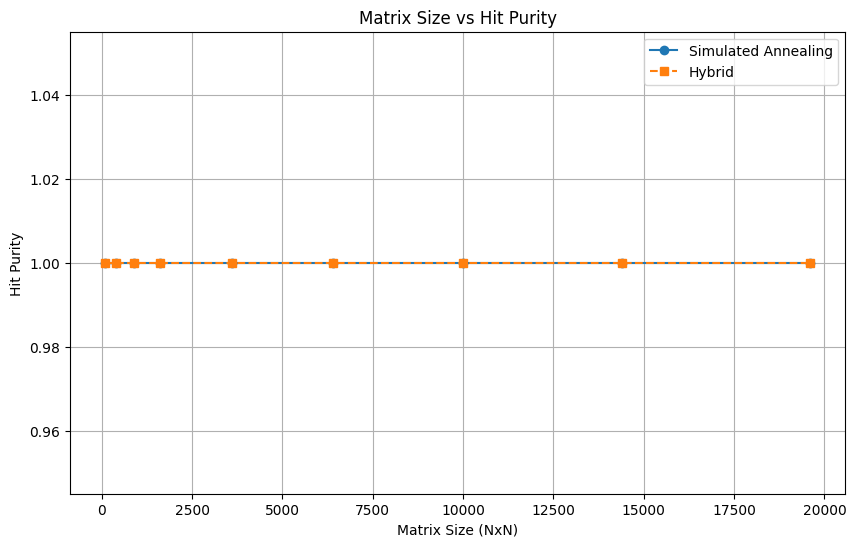

In [2]:
import matplotlib.pyplot as plt
import pickle
import pandas as pd

# Load the progress data from the pickle file
def load_progress(pickle_file):
    """Load data from a pickle file."""
    try:
        with open(pickle_file, 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        print(f"Pickle file {pickle_file} not found.")
        return []

# Plot function for Hit Efficiency, Fake Rate, and Hit Purity against Matrix Size
def plot_results_by_matrix_size(pickle_file='progress.pkl'):
    # Load the results from the pickle file
    results = load_progress(pickle_file)
    if not results:
        print("No data found in the pickle file.")
        return

    # Convert to DataFrame
    results_df = pd.DataFrame(results)

    # Filter out entries without accuracy metrics (like TrueSolution rows)
    results_df = results_df[results_df['Solver'] != "TrueSolution"]

    # Add a Matrix Size column
    results_df['Matrix Size'] = 4 * (results_df['N_PARTICLES'] ** 2)

    # Solver name mappings
    solver_names = {
        "qubosolverSA": "Simulated Annealing",
        "qubosolverHr": "Hybrid",
        "qubosolverQA": "Quantum Annealing"
    }

    solvers = results_df['Solver'].unique()  # Get unique solvers

    # Define styles
    linestyles = ['-', '--', '-.', ':']  # Different line styles
    markers = ['o', 's', '^', 'D']       # Different markers

    # Ensure there are enough styles for all solvers
    styles = zip(linestyles * (len(solvers) // len(linestyles) + 1),
                 markers * (len(solvers) // len(markers) + 1))

    style_map = {solver: style for solver, style in zip(solvers, styles)}

    # Plot 1: Matrix Size vs Hit Efficiency
    plt.figure(figsize=(10, 6))
    for solver in solvers:
        solver_data = results_df[results_df['Solver'] == solver]
        linestyle, marker = style_map[solver]
        plt.plot(solver_data['Matrix Size'], solver_data['Hit Efficiency'],
                 label=solver_names.get(solver, solver), linestyle=linestyle, marker=marker)
    plt.title("Matrix Size vs Hit Efficiency")
    plt.xlabel("Matrix Size (NxN)")
    plt.ylabel("Hit Efficiency")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot 2: Matrix Size vs Fake Rate
    plt.figure(figsize=(10, 6))
    for solver in solvers:
        solver_data = results_df[results_df['Solver'] == solver]
        linestyle, marker = style_map[solver]
        plt.plot(solver_data['Matrix Size'], solver_data['Fake Rates'],
                 label=solver_names.get(solver, solver), linestyle=linestyle, marker=marker)
    plt.title("Matrix Size vs Fake Rate")
    plt.xlabel("Matrix Size (NxN)")
    plt.ylabel("Fake Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot 3: Matrix Size vs Hit Purity
    plt.figure(figsize=(10, 6))
    for solver in solvers:
        solver_data = results_df[results_df['Solver'] == solver]
        linestyle, marker = style_map[solver]
        plt.plot(solver_data['Matrix Size'], solver_data['Hit Purity'],
                 label=solver_names.get(solver, solver), linestyle=linestyle, marker=marker)
    plt.title("Matrix Size vs Hit Purity")
    plt.xlabel("Matrix Size (NxN)")
    plt.ylabel("Hit Purity")
    plt.legend()
    plt.grid(True)
    plt.show()


# Generate the plots
plot_results_by_matrix_size('progress.pkl')


In [3]:
import pickle
import pandas as pd

# Load the progress data from the pickle file
def load_progress(pickle_file):
    """Load data from a pickle file."""
    try:
        with open(pickle_file, 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        print(f"Pickle file {pickle_file} not found.")
        return []

# Generate LaTeX table
def generate_latex_table(pickle_file='progress.pkl'):
    # Load the results from the pickle file
    results = load_progress(pickle_file)
    if not results:
        print("No data found in the pickle file.")
        return None

    # Convert to DataFrame
    results_df = pd.DataFrame(results)

    # Filter out entries without accuracy metrics (like TrueSolution rows)
    results_df = results_df[results_df['Solver'] != "TrueSolution"]

    # Group by solver and calculate mean metrics
    summary = results_df.groupby('Solver').agg(
        Hit_Purity=('Hit Purity', 'mean'),
        Hit_Efficiency=('Hit Efficiency', 'mean'),
        Fake_Rate=('Fake Rates', 'mean')
    ).reset_index()

    # Rename solvers for better readability
    solver_names = {
        "qubosolverSA": "Simulated Annealing",
        "qubosolverHr": "Hybrid",
        "qubosolverQA": "Quantum Annealing"
    }
    summary['Solver'] = summary['Solver'].map(solver_names).fillna(summary['Solver'])

    # Generate LaTeX table
    latex_table = summary.to_latex(
        index=False,
        float_format="%.2f",
        caption="QUBO Solver Results Summary",
        label="tab:qubo_results"
    )
    
    print("LaTeX Table:\n")
    print(latex_table)
    return latex_table

# Generate and display the LaTeX table
latex_code = generate_latex_table('progress.pkl')

LaTeX Table:

\begin{table}
\caption{QUBO Solver Results Summary}
\label{tab:qubo_results}
\begin{tabular}{lrrr}
\toprule
Solver & Hit_Purity & Hit_Efficiency & Fake_Rate \\
\midrule
Hybrid & 1.00 & 1.00 & 0.00 \\
Simulated Annealing & 1.00 & 1.00 & 0.00 \\
\bottomrule
\end{tabular}
\end{table}



In [4]:
import pickle
import pandas as pd

# Load the progress data from the pickle file
def load_progress(pickle_file):
    """Load data from a pickle file."""
    try:
        with open(pickle_file, 'rb') as f:
            return pickle.load(f)
    except FileNotFoundError:
        print(f"Pickle file {pickle_file} not found.")
        return []

# Generate LaTeX table
def generate_latex_table_detailed(pickle_file='progress.pkl'):
    # Load the results from the pickle file
    results = load_progress(pickle_file)
    if not results:
        print("No data found in the pickle file.")
        return None

    # Convert to DataFrame
    results_df = pd.DataFrame(results)

    # Filter out entries without accuracy metrics (like TrueSolution rows)
    results_df = results_df[results_df['Solver'] != "TrueSolution"]

    # Add a Matrix Size column
    results_df['Matrix Size'] = 4 * (results_df['N_PARTICLES'] ** 2)

    # Sort by Matrix Size
    results_df = results_df.sort_values(by='Matrix Size')

    # Select relevant columns
    table_data = results_df[['Matrix Size', 'Solver', 'Hit Purity', 'Hit Efficiency', 'Fake Rates']]

    # Rename solvers for better readability
    solver_names = {
        "qubosolverSA": "Simulated Annealing",
        "qubosolverHr": "Hybrid",
        "qubosolverQA": "Quantum Annealing"
    }
    table_data['Solver'] = table_data['Solver'].map(solver_names).fillna(table_data['Solver'])

    # Generate LaTeX table
    latex_table = table_data.to_latex(
        index=False,
        float_format="%.2f",
        caption="QUBO Solver Results for Increasing Matrix Sizes",
        label="tab:qubo_matrix_results"
    )
    
    print("LaTeX Table:\n")
    print(latex_table)
    return latex_table

# Generate and display the LaTeX table
latex_code = generate_latex_table_detailed('progress.pkl')


LaTeX Table:

\begin{table}
\caption{QUBO Solver Results for Increasing Matrix Sizes}
\label{tab:qubo_matrix_results}
\begin{tabular}{rlrrr}
\toprule
Matrix Size & Solver & Hit Purity & Hit Efficiency & Fake Rates \\
\midrule
100 & Simulated Annealing & 1.00 & 1.00 & 0.00 \\
100 & Hybrid & 1.00 & 1.00 & 0.00 \\
400 & Simulated Annealing & 1.00 & 1.00 & 0.00 \\
400 & Hybrid & 1.00 & 1.00 & 0.00 \\
900 & Simulated Annealing & 1.00 & 1.00 & 0.00 \\
900 & Hybrid & 1.00 & 1.00 & 0.00 \\
1600 & Simulated Annealing & 1.00 & 1.00 & 0.00 \\
1600 & Hybrid & 1.00 & 1.00 & 0.00 \\
3600 & Simulated Annealing & 1.00 & 1.00 & 0.00 \\
3600 & Hybrid & 1.00 & 1.00 & 0.00 \\
6400 & Simulated Annealing & 1.00 & 1.00 & 0.00 \\
6400 & Hybrid & 1.00 & 1.00 & 0.00 \\
10000 & Simulated Annealing & 1.00 & 1.00 & 0.00 \\
10000 & Hybrid & 1.00 & 1.00 & 0.00 \\
14400 & Simulated Annealing & 1.00 & 1.00 & 0.00 \\
14400 & Hybrid & 1.00 & 1.00 & 0.00 \\
19600 & Simulated Annealing & 1.00 & 1.00 & 0.00 \\
19600 & Hybr

/tmp/ipykernel_1870/201737438.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_data['Solver'] = table_data['Solver'].map(solver_names).fillna(table_data['Solver'])


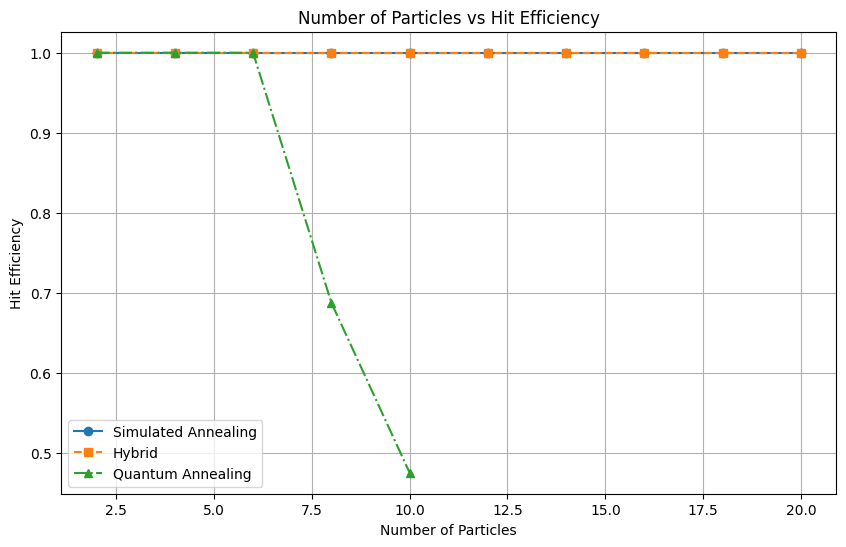

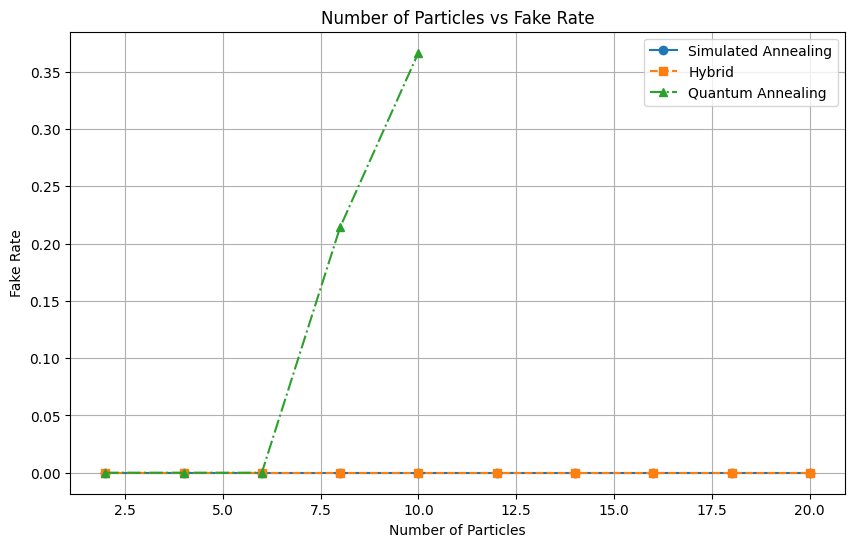

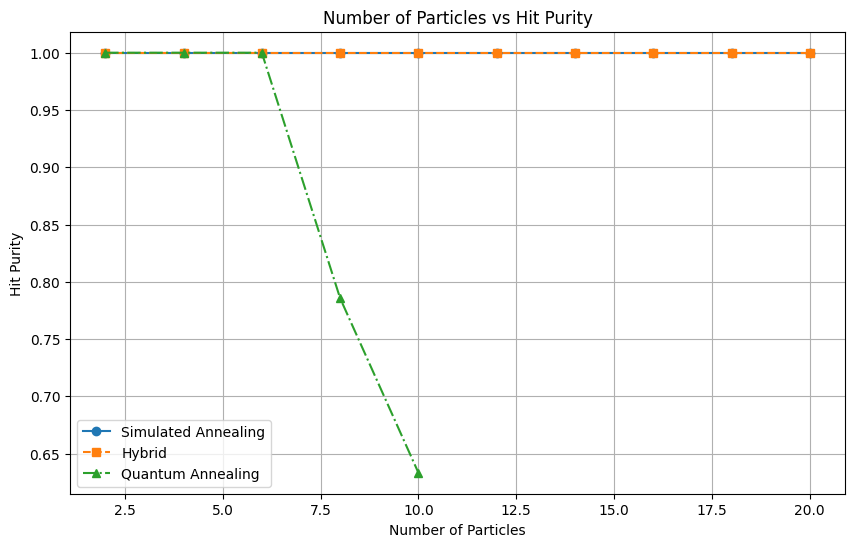

In [6]:
import matplotlib.pyplot as plt

# Plot function for Hit Efficiency, Fake Rate, and Hit Purity
def plot_results(results_df):
    # Solver name mappings
    solver_names = {
        "qubosolverSA": "Simulated Annealing",
        "qubosolverHr": "Hybrid",
        "qubosolverQA": "Quantum Annealing"
    }
    
    solvers = results_df['Solver'].unique()  # Get unique solvers
    
    # Define styles
    linestyles = ['-', '--', '-.', ':']  # Different line styles
    markers = ['o', 's', '^', 'D']       # Different markers
    
    # Ensure there are enough styles for all solvers
    styles = zip(linestyles * (len(solvers) // len(linestyles) + 1), 
                 markers * (len(solvers) // len(markers) + 1))
    
    style_map = {solver: style for solver, style in zip(solvers, styles)}
    
    # Plot 1: Number of Particles vs Hit Efficiency
    plt.figure(figsize=(10, 6))
    for solver in solvers:
        solver_data = results_df[results_df['Solver'] == solver]
        linestyle, marker = style_map[solver]
        plt.plot(solver_data['N_PARTICLES'], solver_data['Hit Efficiency'], 
                 label=solver_names.get(solver, solver), linestyle=linestyle, marker=marker)
    plt.title("Number of Particles vs Hit Efficiency")
    plt.xlabel("Number of Particles")
    plt.ylabel("Hit Efficiency")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot 2: Number of Particles vs Fake Rate
    plt.figure(figsize=(10, 6))
    for solver in solvers:
        solver_data = results_df[results_df['Solver'] == solver]
        linestyle, marker = style_map[solver]
        plt.plot(solver_data['N_PARTICLES'], solver_data['Fake Rate'], 
                 label=solver_names.get(solver, solver), linestyle=linestyle, marker=marker)
    plt.title("Number of Particles vs Fake Rate")
    plt.xlabel("Number of Particles")
    plt.ylabel("Fake Rate")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot 3: Number of Particles vs Hit Purity
    plt.figure(figsize=(10, 6))
    for solver in solvers:
        solver_data = results_df[results_df['Solver'] == solver]
        linestyle, marker = style_map[solver]
        plt.plot(solver_data['N_PARTICLES'], solver_data['Hit Purity'], 
                 label=solver_names.get(solver, solver), linestyle=linestyle, marker=marker)
    plt.title("Number of Particles vs Hit Purity")
    plt.xlabel("Number of Particles")
    plt.ylabel("Hit Purity")
    plt.legend()
    plt.grid(True)
    plt.show()


# Generate the plots
plot_results(results_df)

In [ ]:
from itertools import product
from scipy.sparse import csc_matrix

def brute_force(A, b):
    A = csc_matrix(A)
    n = len(b) 

    best_solution = None
    best_energy = np.inf
    for config in product([0, 1], repeat=n):
        config = np.array(config)
        
        #calculate energy: E = x^T A x + b^T x
        energy = config @ A @ config + b @ config
        if energy < best_energy:
            best_energy = energy
            best_solution = config

    print(f"Best Solution: {best_solution}")
    print(f"Best Energy: {best_energy}")

    return best_solution


brute_force_solution = brute_force(A, b)
print(f"Brute Force Solution: {brute_force_solution}")




Best Solution: [1 0 0 1 1 0 0 1]
Best Energy: -4.0
Brute Force Solution: [1 0 0 1 1 0 0 1]
